In [1]:
# install libraries
%pip install category_encoders==2.5.0
%pip install hyperopt==0.2.7
%pip install lightgbm==3.3.0
%pip install matplotlib==3.5.1
%pip install numpy==1.22.4
%pip install pandas==1.3.0
%pip install scikit_learn==1.1.2
%pip install seaborn==0.12.0
%pip install shap==0.40.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached lightgbm-3.3.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [91 lines of output]
      INFO:root:running bdist_wheel
      /private/var/folders/tp/r9md9jss78nf28s4cq7vcg580000gn/T/pip-install-s9_h6x3i/lightgbm_49e6b8dec5f048b99081df1ff0980722/setup.py:220: SetuptoolsDeprecationWarning: setup.py install is deprecated.
      !!
      
              ********************************************************************************
              Please avoid running ``setup.py`` directly.
              Instead, use pypa/build, pypa/installer or other
              standards-based tools.
      
              See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
              *************

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
path = os.getcwd()
import sys
sys.path.append("")
from utils import *

import pandas as pd
import numpy as np

import random

import category_encoders as ce
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
import bisect

from sklearn.preprocessing import OneHotEncoder

from hyperopt import fmin, tpe, hp, anneal, Trials

import os
import gc

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x)
%load_ext autoreload
%autoreload 2

# Description of Columns
| Columns            | Description                                           |
|--------------------|-------------------------------------------------------|
| User_id            | User Identifier                                       |
| employment_type    | Employment Type (Salaried, Self-Employed)             |
| tier_of_employment | Tier of Employment (According to company performance) |
| industry           | Industry of Employer                                  |
| role               | Role of User in company                               |
| work_experience    | Total Work Experience                                 |
| total_income       | Total Income of customer                              |
| gender             | Gender of Customer                                    |
| married            | Single / Married / Divorced / Widowed etc.            |
| dependents         | No. of dependents on user                             |
| home_type          | Rented / Owned etc.                                   |
| pincode            | Middle 3 digit of Pincode                             |
| has_social_profile | Has FB/Twitter or any other social profile            |
| is_verified        | Is Social Profile Verified                            |
| delinq_2yrs        | Number of loan delinquencies in last 2 years          |
| total_payement     | Total Payment made towards loan in last 2 years       |
| received_principal | Total Principal paid towards loan in last 2 years     |
| interest_received  | Total Interest Received towards loan in last 2 years  |
| number_of_loans    | Number of Loans in last 2 years                       |
| emi_1_dpd          | DPD in repayment of 1st EMI (0, 30+, 60+, 90+)        |
| emi_2_dpd          | DPD in repayment of 2nd EMI (0, 30+, 60+, 90+)        |
| emi_3_dpd          | DPD in repayment of 3rd EMI (0, 30+, 60+, 90+)        |
| emi_4_dpd          | DPD in repayment of 4th EMI (0, 30+, 60+, 90+)        |
| emi_5_dpd          | DPD in repayment of 5th EMI (0, 30+, 60+, 90+)        |
| emi_6_dpd          | DPD in repayment of 6th EMI (0, 30+, 60+, 90+)        |
| max_dpd            | Maximum DPD (0, 30+, 60+, 90+) attained               |
| yearmo             | Year and month of loan application (YYYYMM format)    |

## Action Items
- Drop Gender Column (can't use gender as distinguishing factor for credit risk)
- According to yearmo, split data in Train, Validation, Hold Out
- DPD Roll Rate Analysis and Window Roll Rate Analysis for defining label (default = dpd X in first Y months, Define X & Y)

In [3]:
#Defining Parameters
data_path = 'credit_risk_data.csv'# Path of data
#Non feature Columns (not to be used as features in model)
id_cols = ['User_id','emi_1_dpd', 'emi_2_dpd', 'emi_3_dpd', 'emi_4_dpd', 'emi_5_dpd', 'emi_6_dpd', 'max_dpd', 'yearmo']
drop_columns = ['gender']

In [4]:
# Read Data and drop Non usable Columns
df = process_data(data_path, drop_columns)
print(df.drop(columns = id_cols).shape)
df.head(5)

(143727, 17)


,User_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,married,dependents,home_type,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
0,7013527,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,125000.000,Yes,4,rent,...,852.690,0,0,90,90,90,90,90,90,202203
1,7014291,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,61000.000,No,1,mortgage,...,4912.530,0,0,0,0,0,0,0,0,202203
2,7014327,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,5-10,100000.000,NaN,3,own,...,3310.680,0,90,90,90,90,90,90,90,202205
3,7014304,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,30000.000,NaN,1,rent,...,1459.760,0,0,0,0,0,0,0,0,202203
4,7031995,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,65000.000,NaN,3,rent,...,1793.000,0,0,0,0,0,0,0,0,202203


In [5]:
# Numeric, Categorical Features, Feature wise null counts and Zero Variance Features
understand_data(df, id_cols)

Numeric Columns : ['total_income', 'dependents', 'delinq_2yrs', 'total_payement', 'received_principal', 'interest_received', 'number_of_loans']

Categorical Columns : ['employment_type', 'tier_of_employment', 'industry', 'role', 'work_experience', 'married', 'home_type', 'pincode', 'has_social_profile', 'is_verified']

Null Counts
employment_type       84642
tier_of_employment    84642
industry                  4
role                      0
work_experience           4
total_income              0
married               48143
dependents                0
home_type                 0
pincode                   0
has_social_profile    47856
is_verified           35803
delinq_2yrs               0
total_payement            0
received_principal        0
interest_received         0
number_of_loans           0
dtype: int64

Zero Variance Columns: Index([], dtype='object')


In [6]:
# Since Data is on timeline
df.yearmo.value_counts()

yearmo
202203    28750
202201    28750
202202    28750
202204    28750
202205    28727
Name: count, dtype: int64

Split data on timeline to make sure model developed is able to predict well on Out of time data
<br>**Train** - Yearmo 202201 to 202203
<br>**Validation** - Yearmo 202204
<br>**Hold Out** - Yearmo 202205 (Out of time data)

In [7]:
train, val, hold_out = data_split(df)

# Define Label (Roll Rate Analysis)
## DPD Roll Rate

In [8]:
# % of customer achieved X dpd (Since everyone starts at 0 dpd so 100% will be at 0 dpd)
dpd_roll_rate(train)

,dpd,user_count,user_percent
0,0,86250,100.0 %
1,30,22073,25.59 %
2,60,8099,9.39 %
3,90,7926,9.19 %


As we can see
<br>- ~25.6% customer paid back after crossing dpd30
<br>- Most of the people who crossed dpd60 are also crossing dpd 90
<br>**Conclusion** - *DPD60 should be right choice as Recovery rate is low post that*

## window Roll Rate

In [9]:
# For DPD 60 analyzing % of customer attain dpd60 on various lifecycle of EMI
window_roll_rate(train, 60)

,first_default_emi,users_count,% of Users
0,1,6546,80.82 %
1,2,1084,13.38 %
2,3,421,5.2 %
3,4,22,0.27 %
4,5,18,0.22 %
5,6,8,0.1 %


As we can see
<br>- 80.8% of Defaulters dafault in 1st EMI and 5.2% default in 3rd EMI, Post 3rd EMI rate is low, so we can conclude people Most of the Defaulter default in 1st 3 EMIs
<br>**Conclusion** - We can use DPD60 in first 3 months as our label

## Label Creation

In [10]:
# We will call Class 1 a defaulter
train = create_label(train, dpd = 60, months = 3)
val = create_label(val, dpd = 60, months = 3)
hold_out = create_label(hold_out, dpd = 60, months = 3)

label columns added to dataframe
label columns added to dataframe
label columns added to dataframe


### Label Distribution

In [11]:
label_distribution([train, val, hold_out], ['Training', 'Validation', 'Hold Out'], 'label')


label distribution of Training
   label  user_count  % users
0      0       78199   90.666
1      1        8051    9.334

label distribution of Validation
   label  user_count  % users
0      0       25941   90.230
1      1        2809    9.770

label distribution of Hold Out
   label  user_count  % users
0      0       26118   90.918
1      1        2609    9.082


- Labels are imbalanced towards class 0
- Same level of Imbalance occure across Train, Validation, Hold Out

# Create Features

In [12]:
# We are adding few features
## - % Amount Paid as interest in past Loan Repayment
## - % of Loans defaulted in last 2 years
train = derived_features(train)
val = derived_features(val)
hold_out = derived_features(hold_out)

# EDA
## Univariate

In [13]:
id_cols.append('label')
e = eda(train, id_cols)

In [14]:
# Univariate Distribution of Numeric Features
e.numeric_summary()

,total_income,dependents,delinq_2yrs,total_payement,received_principal,interest_received,number_of_loans,interest_received_ratio,total_payement_per_loan,delinq_2yrs_ratio
count,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000
mean,72337.323,2.001,0.280,10806.131,8371.521,2354.687,0.006,0.238,39.107,0.001
std,58969.955,1.410,0.798,8603.037,7202.593,2458.578,0.098,0.146,834.130,0.043
min,4800.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,45000.000,1.000,0.000,4655.845,3091.600,841.812,0.000,0.135,0.000,0.000
50%,61174.270,2.000,0.000,8173.695,6000.000,1630.580,0.000,0.200,0.000,0.000
75%,86000.000,3.000,0.000,14136.720,11550.000,2902.170,0.000,0.310,0.000,0.000
max,7141778.000,4.000,22.000,57777.580,35000.010,23450.380,5.000,0.845,41875.060,5.000


In [15]:
# Categorical Features Summary
e.categorical_summary()

,employment_type,tier_of_employment,industry,role,work_experience,married,home_type,pincode,has_social_profile,is_verified
count,35390,35390,86247,86250,86247,57339,86250,86250,57460,64967
unique,2,7,8985,46,8,2,5,838,2,3
top,Salaried,B,0,KHMbckjadbckIFGCASEWdkcndwkcnCCM,0,No,mortgage,XX945X,No,Verified
freq,28740,11110,46940,13317,46940,28835,42088,993,28838,21729


## Bivariate

### Correlation

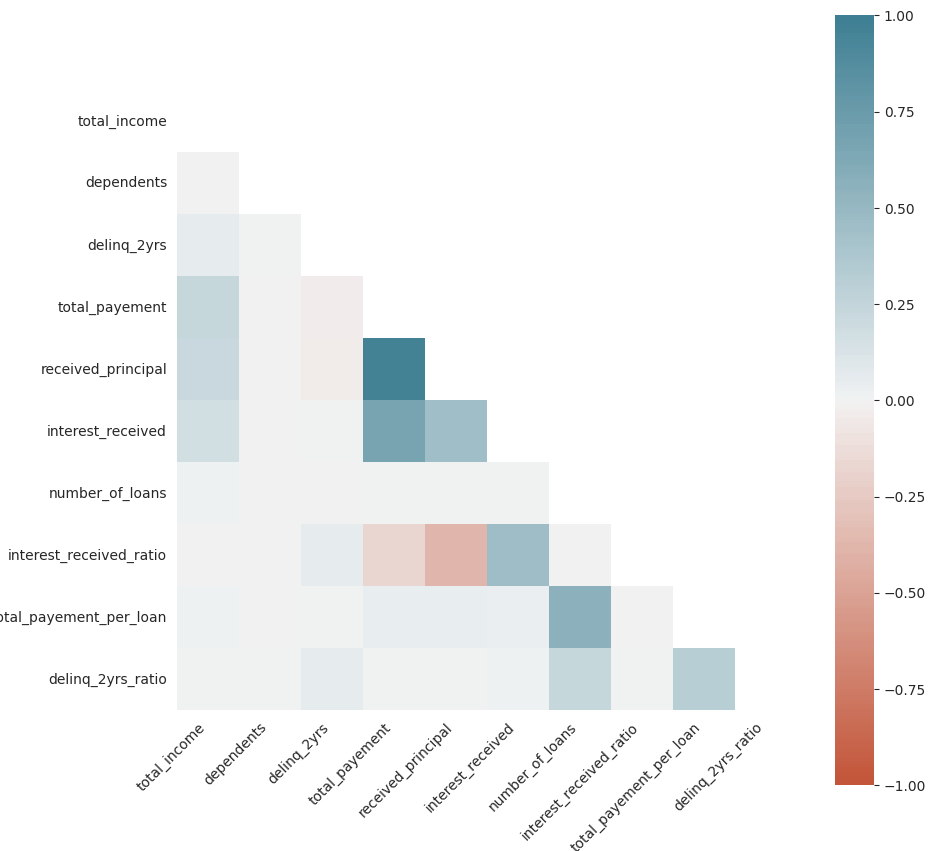

In [16]:
e.correlation_plot()

Some Observations
<br> - Total payment and Received Principal are highly correlated (0.96)
<br> - Interest Received and Total payment are mildely correlated (0.67)

### Box Plot vs Label

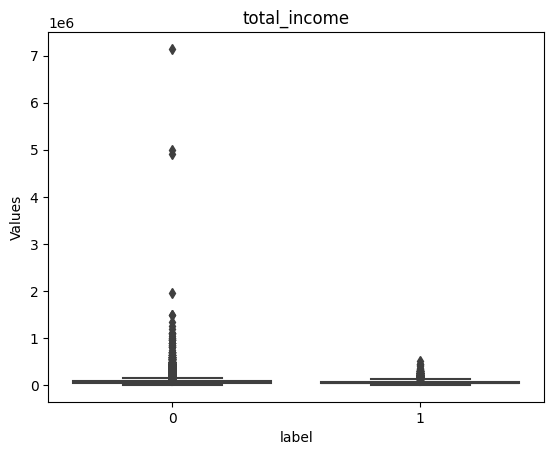

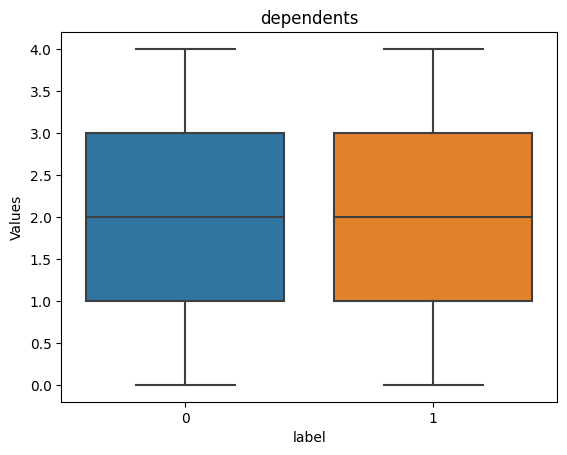

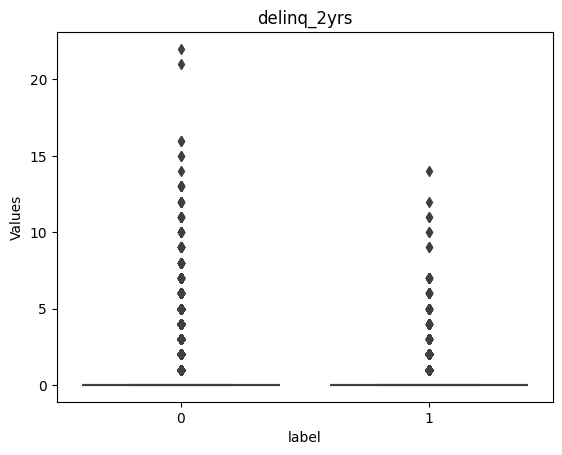

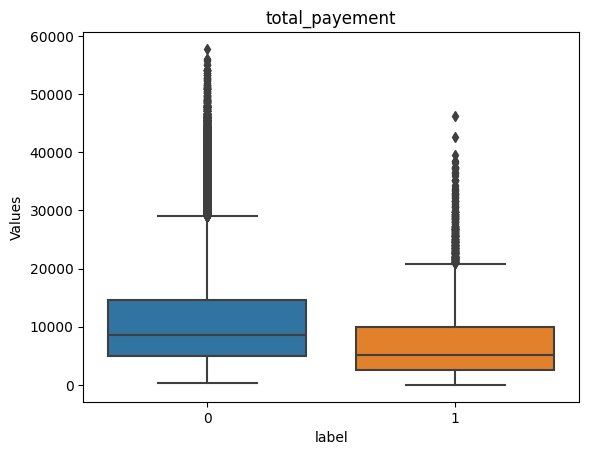

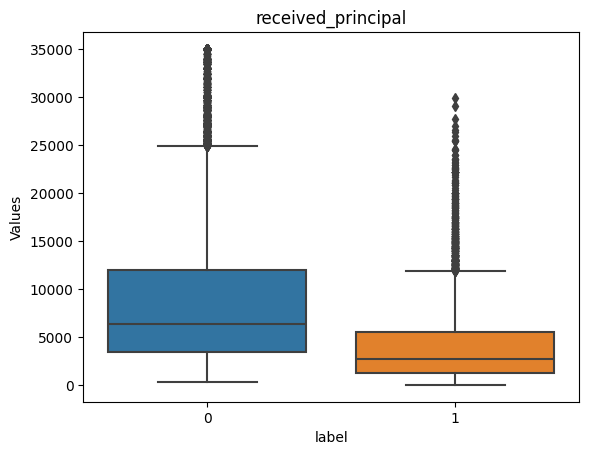

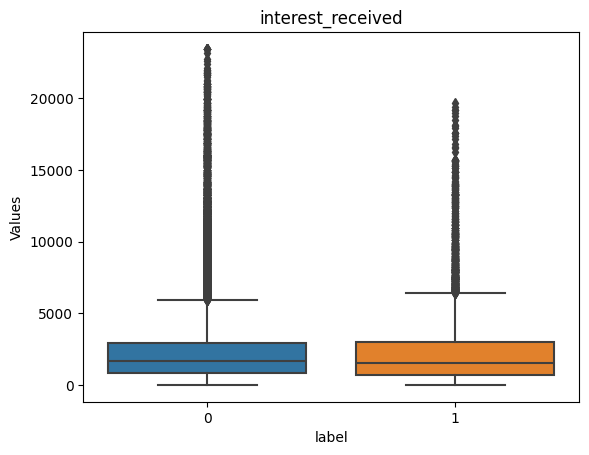

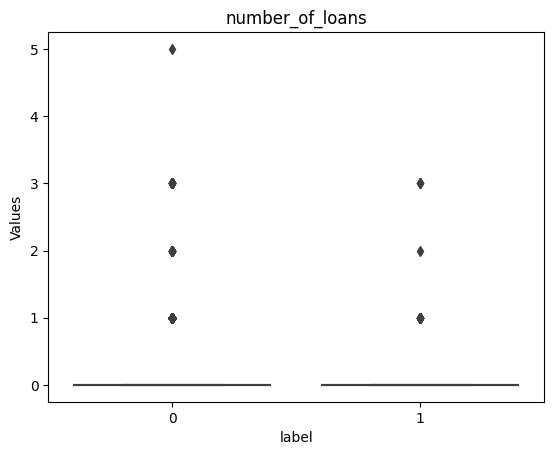

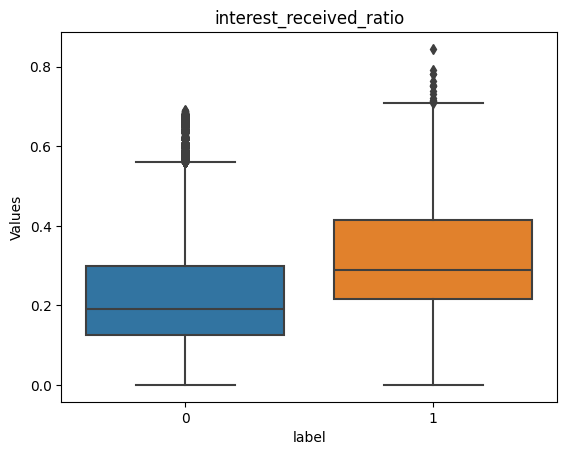

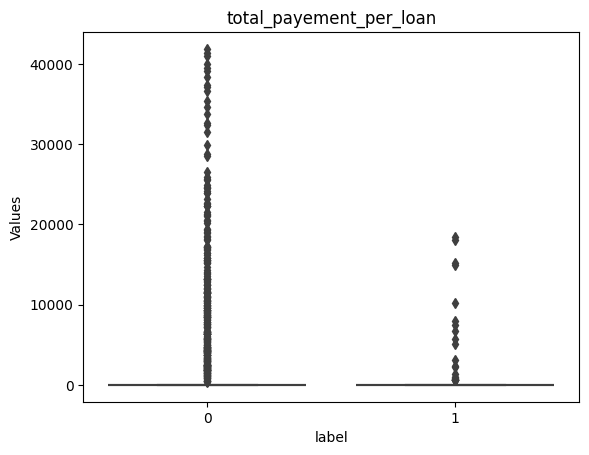

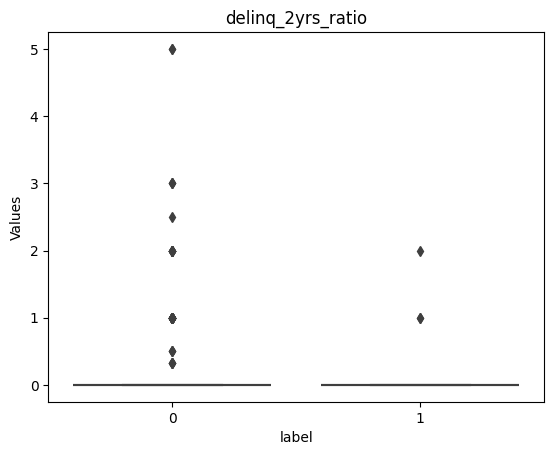

In [17]:
# Box Plot Seggregated by Defaulter and Non Defaulters
e.box_plot(group = ['label'])

Observation
- Distribution of Total Payment, Received Principal, Interest Received Ratio is different for Defaulters and Non-Defaulters
<br> 
<br>these can be some important features

# Categorical Features Transformation

Please Refer
<br> [Paper](https://arxiv.org/pdf/1904.13001.pdf)
<br> [Library](https://contrib.scikit-learn.org/category_encoders/)
<br> to understand Target Encoding better

In [18]:
cat_cols = train.drop(columns = id_cols).select_dtypes(include=['category', 'object']).columns
params = {"verbose":0,
          "cols":None,
          "drop_invariant":False,
          "return_df":True,
          "handle_missing":'value',
          "handle_unknown":'value',
          "min_samples_leaf":5000,
          "smoothing":1}
target_encoder = categorical_encoding(params)
target_encoder.fit(train, cat_cols, 'label')

In [19]:
train = target_encoder.transform(train)
val = target_encoder.transform(val)
hold_out = target_encoder.transform(hold_out)

# Feature Selection
<br> There can be many methods to do feature selection like Mrmr, KS, Information Gain etc., Random Forest and Deep Decision Tree can also be used as Feature Selection</br>
<br> 
**Random Forest** - Since Random Forest subset features too, so every feature gets chance to split tree
<br> 
**Decision Tree** - Decision Tree Uses Greedy Algorithm to split Tree so choose between 2 correlated features which one is best
<br>
<br>Drop features which are of 0 importance in Random Forest and Decision Tree

## Random Forest

In [20]:
rf_params = {"n_estimators":250, 'criterion':'entropy','verbose':False, 'n_jobs':25}
rf_zero_imp = random_forest_zero_importance(train, id_cols, 'label', rf_params)

## Decision Tree

In [21]:
dt_params = {}
dt_zero_imp = decision_tree_zero_importance(train, id_cols, 'label', dt_params)

## Zero Importance Columns

In [22]:
drop_cols = list(set(rf_zero_imp) & set(dt_zero_imp))
print(drop_cols)

['pincode']


Since Pincode is of 0 importanc in Random Forest and Decision Tree, we will drop this features in model

# Model Development
## Hyperparameter Tuning

We will try to search hyperparameter using Hyperopt, Following are relevant links to understand Hyperopt better
- [Paper](https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf)
- [Library](http://hyperopt.github.io/hyperopt/)

Hyperopt tries to minimize of score (to be defined by user) by smartly iterating though various combination of hypeparameters in given space
<br>
Score = (Train ROC AUC - Val ROC AUC + 1)/(Val ROC AUC)
<br>
<br>
**Intution**
- Train ROC AUC - Val ROC AUC will reduce overfitting
<br> 
- 1/(Val ROC AUC) will increase ROC AUC for Validation Set
</br>
After Every Iteration we are appending results to the results of existing runs and saving to hyperopt_results.csv, so in case we halt the run in between, we will not loose results

<br></br>
**Setting**
<br>- Loss Function = LogLoss
<br>- Implementation = Lightgbm Implementation of Boosting Algorithm 
<br>- Primary Evalution Metric - ROC AUC
<br>- Hypeparameter Selection - Hyperopt

In [23]:
result_ho = pd.DataFrame()
i = 0

## Defining Objective Function
## will return the score to optimise
def objective(space):
    
    global i
    global result_ho
    
    #Creating Lightgbm DataFrame
    lgb_train = lgb.Dataset(train.drop(columns = id_cols+drop_cols), label = train.label)
    lgb_val = lgb.Dataset(val.drop(columns = id_cols+drop_cols), label = val.label)

    #Parameters of model
    params = {
        'num_leaves': int(space['num_leaves']),
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'objective': 'binary',
        'metric': 'auc',
        "boosting": "gbdt",
        'feature_fraction' : space['feature_fraction'],
        'max_bin' : int(space['max_bin']),
        'min_data_in_leaf': int(space['min_data_in_leaf']),
        "min_data_in_bin": int(space['min_data_in_bin']),
        "bagging_freq": 20,
        "random_seed": 2019,
        "lambda_l1": space['lambda_l1'],
        "lambda_l2": space['lambda_l2'],
        'pos_bagging_fraction' : space['pos_bagging_fraction'],
        'neg_bagging_fraction' : space['neg_bagging_fraction'],
        'verbose': -1
    }

    evals_result = {}
    
    clf = lgb.train(params,lgb_train,20000,valid_sets=lgb_val,
                    valid_names='val',
                    callbacks=[early_stopping(stopping_rounds=50),
                    log_evaluation(period=1)
                    ]
                    )
    
    gc.collect()
    
    result = pd.DataFrame(clf.params, index=[0])
    
    ## Calculating AUC
    pred_train = clf.predict(train[clf.feature_name()])
    pred_val = clf.predict(val[clf.feature_name()])
    pred_hold_out = clf.predict(hold_out[clf.feature_name()])

    gc.collect()
    train_auc = roc_auc_score(train.label, pred_train)#, num_iteration=clf.best_iteration)
    val_auc = roc_auc_score(val.label, pred_val)#, num_iteration=clf.best_iteration)
    hold_out_auc = roc_auc_score(hold_out.label, pred_hold_out)#, num_iteration=clf.best_iteration)
    gc.collect()

    score = (abs(train_auc - val_auc) + 1)/((1+val_auc)*(1+val_auc))
    
    result["train_auc"] = train_auc
    result["val_auc"] = val_auc
    result["hold_out_auc"] = hold_out_auc
    result["train_test_diff"] = train_auc - val_auc
    result["n_estimators"] = clf.best_iteration
    result["score"] = score
    
    del clf
    
    result_ho = pd.concat([result_ho, result], ignore_index=True)
    result_ho.to_csv('hyperopt_results.csv', index=False)
    i = i+1
    
    return (score)

In [24]:
## Hyperparameter space
## Space is selection of data point from the given distribution
## Distribution is defined for every hyperparameter seperately
space = {
    'num_leaves': hp.quniform('num_leaves', 2, 24, 1), # Uniform integer between 2 and 24
    'max_depth': hp.quniform('max_depth', 2, 12, 1), # Uniform integer between 2 and 12
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.015), # Values between 0.005 to 0.015
    'feature_fraction' : hp.uniform('feature_fraction', 0.1, 1), # Values between 0.1 to 1
    'max_bin' : hp.quniform('max_bin', 10, 100, 10),
    'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 25, 1000, 25),
    'lambda_l1' : hp.uniform('lambda_l1', 0, 50),
    'lambda_l2' : hp.uniform('lambda_l2', 0, 50),
    'min_data_in_bin' : hp.quniform('min_data_in_bin', 5, 100, 5),
    'pos_bagging_fraction' : hp.uniform('pos_bagging_fraction', 0.1, 1),
    'neg_bagging_fraction' : hp.uniform('neg_bagging_fraction', 0.1, 1)
    }

In [25]:
from lightgbm import early_stopping, log_evaluation

In [ ]:
best=fmin(fn = objective, # function to optimize
          space = space, # space from which hyperparameter to be choosen
          algo = tpe.suggest, # optimization algorithm, hyperopt will select its parameters automatically
          max_evals = 50,
          rstate = np.random.default_rng(7)
         )

[1]	val's auc: 0.550845                               
Training until validation scores don't improve for 50 rounds
[2]	val's auc: 0.561219                               
[3]	val's auc: 0.681736                               
[4]	val's auc: 0.798884                               
[5]	val's auc: 0.783088                               
[6]	val's auc: 0.808817                               
[7]	val's auc: 0.840146                               
[8]	val's auc: 0.876035                               
[9]	val's auc: 0.885364                               
[10]	val's auc: 0.879179                              
[11]	val's auc: 0.876875                              
[12]	val's auc: 0.873386                              
[13]	val's auc: 0.875909                              
[14]	val's auc: 0.88268                               
[15]	val's auc: 0.881814                              
[16]	val's auc: 0.883012                              
[17]	val's auc: 0.880463                              
[18]

## Model Selection

From Hyperopt Results we will choose best parameters according to following criteria. It is not necessary we use that particular hyperparameter
- High Score
- High Validation AUC
- Low Overfitting

In [25]:
hyperopt_results = pd.read_csv('hyperopt_results.csv')

In [26]:
hyperopt_results.head(5)

,num_leaves,max_depth,learning_rate,objective,metric,boosting,feature_fraction,max_bin,min_data_in_leaf,min_data_in_bin,...,neg_bagging_fraction,verbose,num_iterations,early_stopping_round,train_auc,val_auc,hold_out_auc,train_test_diff,n_estimators,score
0,18,3,0.009,binary,auc,gbdt,0.202,80,875,55,...,0.647,-1,20000,50,0.891,0.894,0.890,-0.003,24,0.279
1,10,6,0.015,binary,auc,gbdt,0.238,10,225,65,...,0.468,-1,20000,50,0.892,0.897,0.895,-0.005,29,0.279
2,9,8,0.009,binary,auc,gbdt,0.789,90,550,55,...,0.866,-1,20000,50,0.913,0.917,0.912,-0.004,27,0.273
3,19,9,0.009,binary,auc,gbdt,0.475,70,100,60,...,0.894,-1,20000,50,0.973,0.964,0.963,0.008,3496,0.261
4,6,12,0.007,binary,auc,gbdt,0.908,60,500,25,...,0.792,-1,20000,50,0.938,0.938,0.937,-0.000,1560,0.266


In [27]:
hyperopt_results.sort_values(by = 'score').head(5)

,num_leaves,max_depth,learning_rate,objective,metric,boosting,feature_fraction,max_bin,min_data_in_leaf,min_data_in_bin,...,neg_bagging_fraction,verbose,num_iterations,early_stopping_round,train_auc,val_auc,hold_out_auc,train_test_diff,n_estimators,score
21,12,9,0.010,binary,auc,gbdt,0.669,100,625,30,...,0.544,-1,20000,50,0.971,0.965,0.964,0.006,3041,0.261
24,13,8,0.007,binary,auc,gbdt,0.679,100,1000,25,...,0.515,-1,20000,50,0.969,0.964,0.963,0.006,5096,0.261
37,8,7,0.009,binary,auc,gbdt,0.951,80,125,30,...,0.341,-1,20000,50,0.968,0.963,0.963,0.005,4420,0.261
22,12,9,0.009,binary,auc,gbdt,0.672,70,650,25,...,0.554,-1,20000,50,0.970,0.964,0.962,0.006,3489,0.261
27,7,10,0.008,binary,auc,gbdt,0.745,100,775,15,...,0.502,-1,20000,50,0.966,0.962,0.961,0.004,6067,0.261


In [32]:
hyperopt_results.sort_values(by = 'val_auc', ascending=False).head(5)

,num_leaves,max_depth,learning_rate,objective,metric,boosting,feature_fraction,max_bin,min_data_in_leaf,min_data_in_bin,...,neg_bagging_fraction,verbose,num_iterations,early_stopping_round,train_auc,val_auc,hold_out_auc,train_test_diff,n_estimators,score
21,12,9,0.010,binary,auc,gbdt,0.669,100,625,30,...,0.544,-1,20000,50,0.971,0.965,0.964,0.006,3041,0.261
25,16,8,0.006,binary,auc,gbdt,0.697,100,975,30,...,0.480,-1,20000,50,0.971,0.964,0.963,0.007,6822,0.261
3,19,9,0.009,binary,auc,gbdt,0.475,70,100,60,...,0.894,-1,20000,50,0.973,0.964,0.963,0.008,3496,0.261
24,13,8,0.007,binary,auc,gbdt,0.679,100,1000,25,...,0.515,-1,20000,50,0.969,0.964,0.963,0.006,5096,0.261
22,12,9,0.009,binary,auc,gbdt,0.672,70,650,25,...,0.554,-1,20000,50,0.970,0.964,0.962,0.006,3489,0.261


In [31]:
# check the minimum score and select the index as best parameter index

best_param_index = hyperopt_results.index[hyperopt_results['score'] == hyperopt_results['score'].min()].tolist()[0]
lgbm_params = dict(hyperopt_results.iloc[best_param_index,:19])

## Selected Model

Lightgbm Details
- [Paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
- [Library](https://lightgbm.readthedocs.io/en/v3.3.2/)

In [33]:
lgb_train = lgb.Dataset(train.drop(columns = id_cols+drop_cols), label = train['label'])
lgb_val = lgb.Dataset(val.drop(columns = id_cols+drop_cols), label = val['label'])
evals_result = {}
clf = lgb.train(lgbm_params, lgb_train, 20000, valid_sets=lgb_val,
                valid_names='val',
                early_stopping_rounds=50,
                verbose_eval=False, evals_result=evals_result)

# Model Evalution

In [34]:
#Predictions from Model on Training, Validation and Hold Out
pred_train = clf.predict(train[clf.feature_name()])
pred_val = clf.predict(val[clf.feature_name()])
pred_hold_out = clf.predict(hold_out[clf.feature_name()])

### ROC AUC, PR AUC, KS Stats

In [35]:
#Printing ROC AUC, PR AUC for Class 1 and Class 0
print("ROC AUC")
roc_auc([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])
print("")
print("Class 1 PR AUC")
pr_auc([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])
print("")
print("Class 0 PR AUC")
pr_auc([1-train.label,1-val.label,1-hold_out.label], [1-pred_train, 1-pred_val, 1-pred_hold_out])
print("")

ROC AUC
0.9709666608309787
0.9649508759429978
0.9635950364843274

Class 1 PR AUC
0.883796268964256
0.8792279856483648
0.8678364668760414

Class 0 PR AUC
0.9963933861427327
0.9949638969488055
0.9953873339982944



### ROC Curve

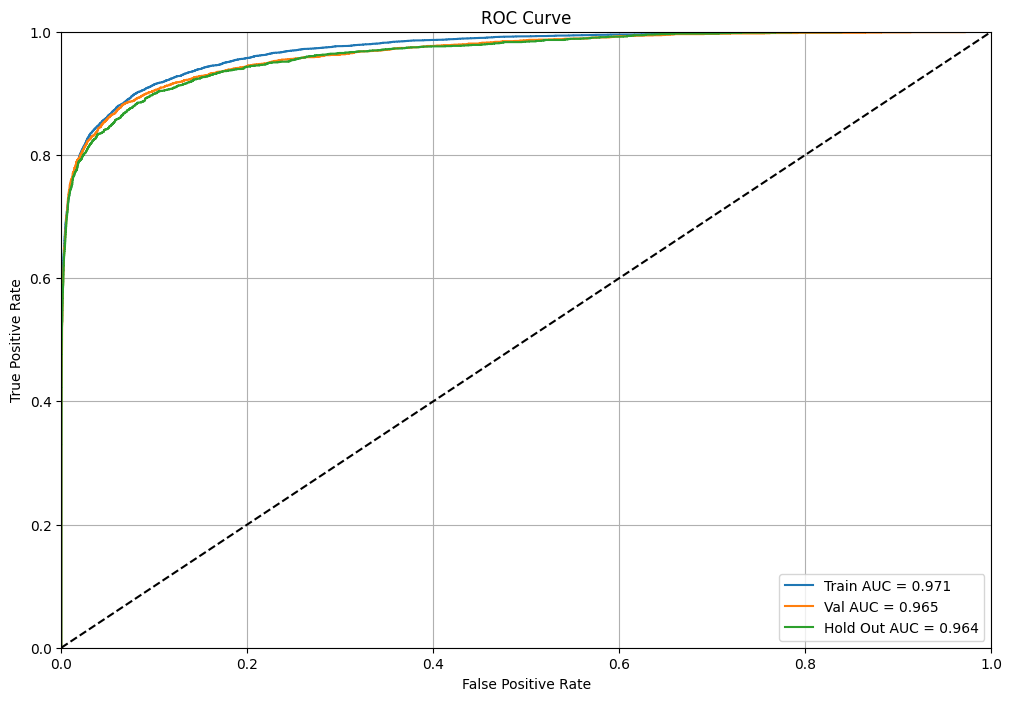

In [36]:
roc_auc_curve([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])

### PR Curve

PR Curve for Class 1


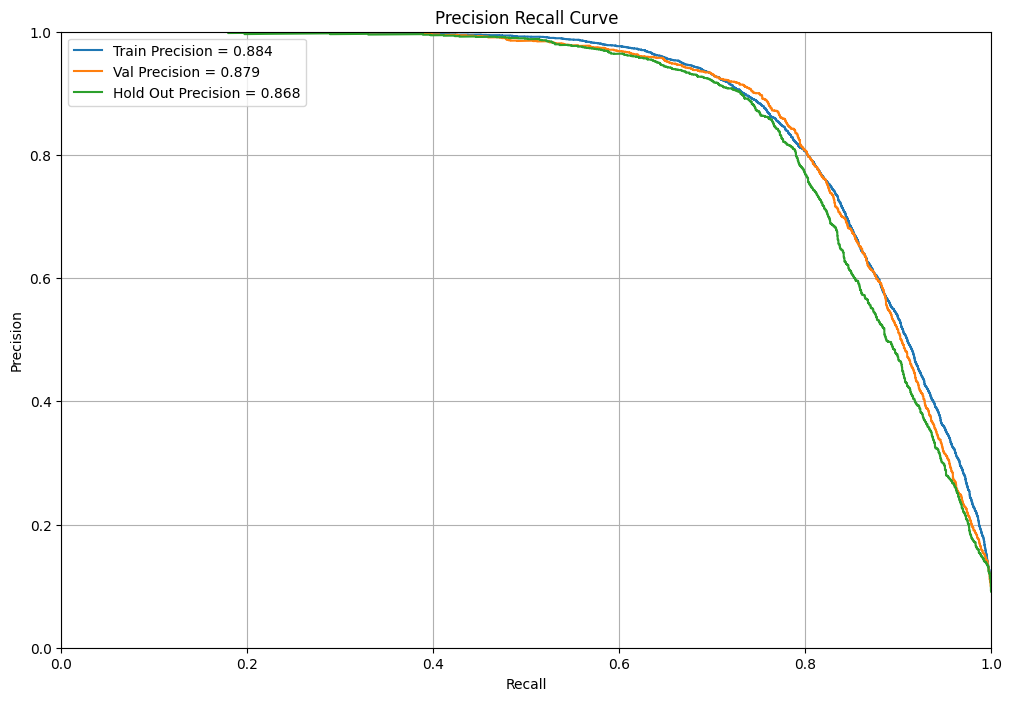

In [37]:
print("PR Curve for Class 1")
pr_auc_curve([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])

PR Curve for Class 0


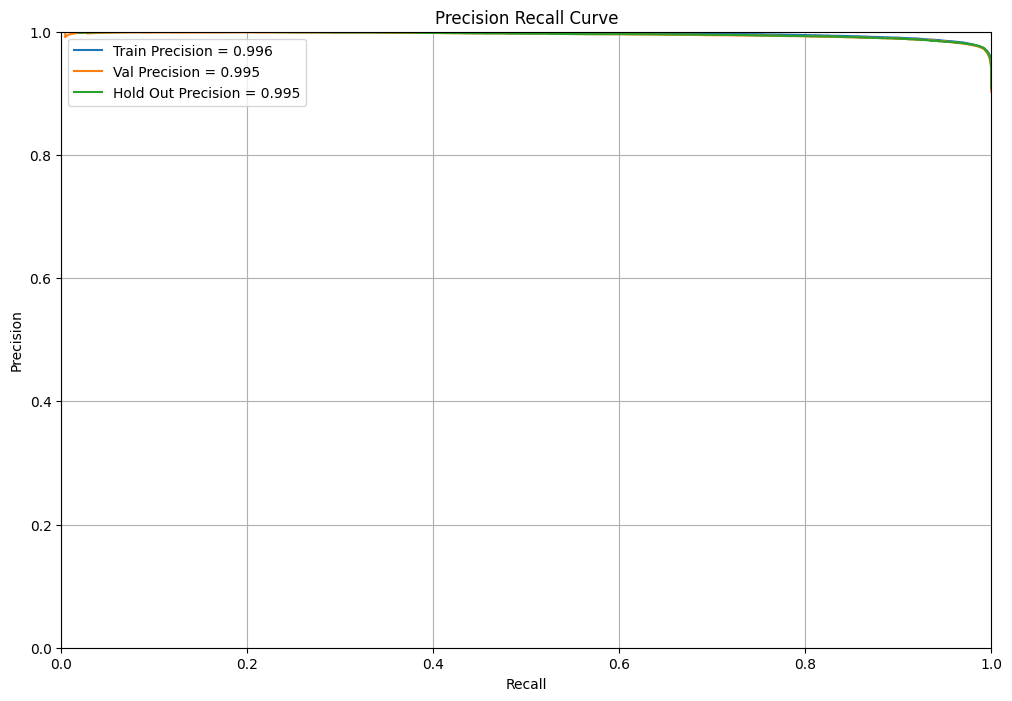

In [38]:
print("PR Curve for Class 0")
pr_auc_curve([1-train.label,1-val.label,1-hold_out.label], [1-pred_train, 1-pred_val, 1-pred_hold_out])

### Score Distribution

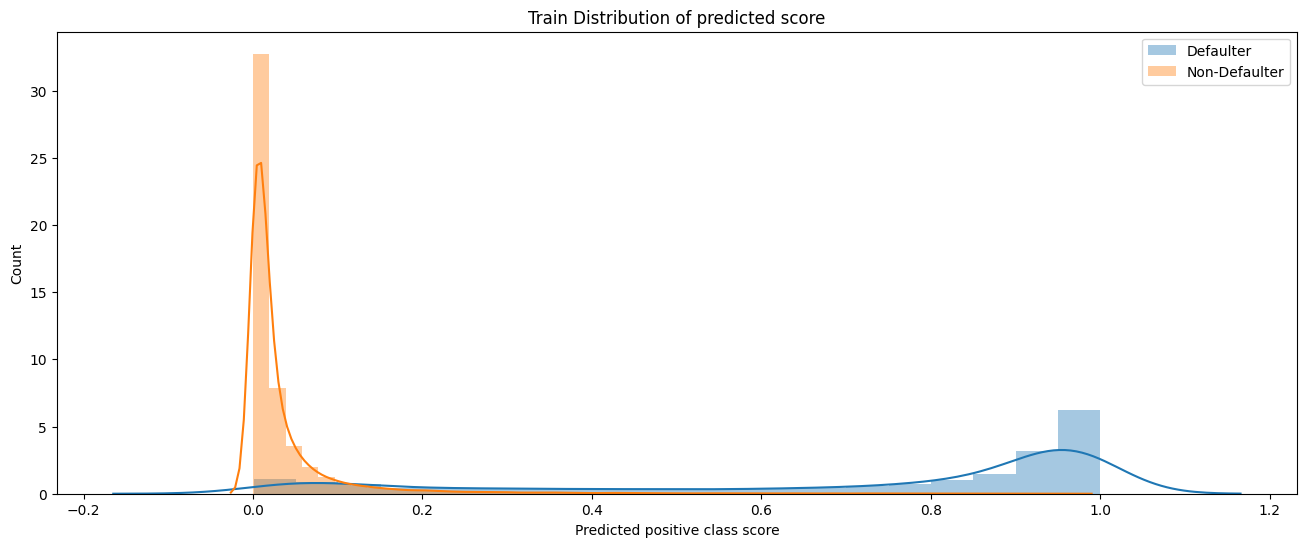

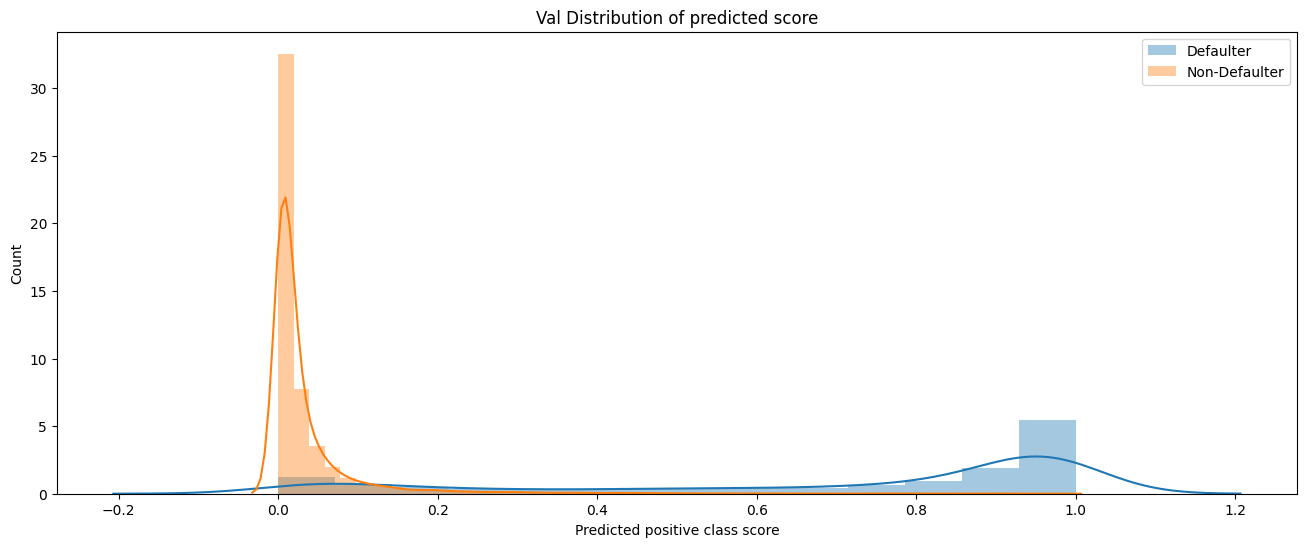

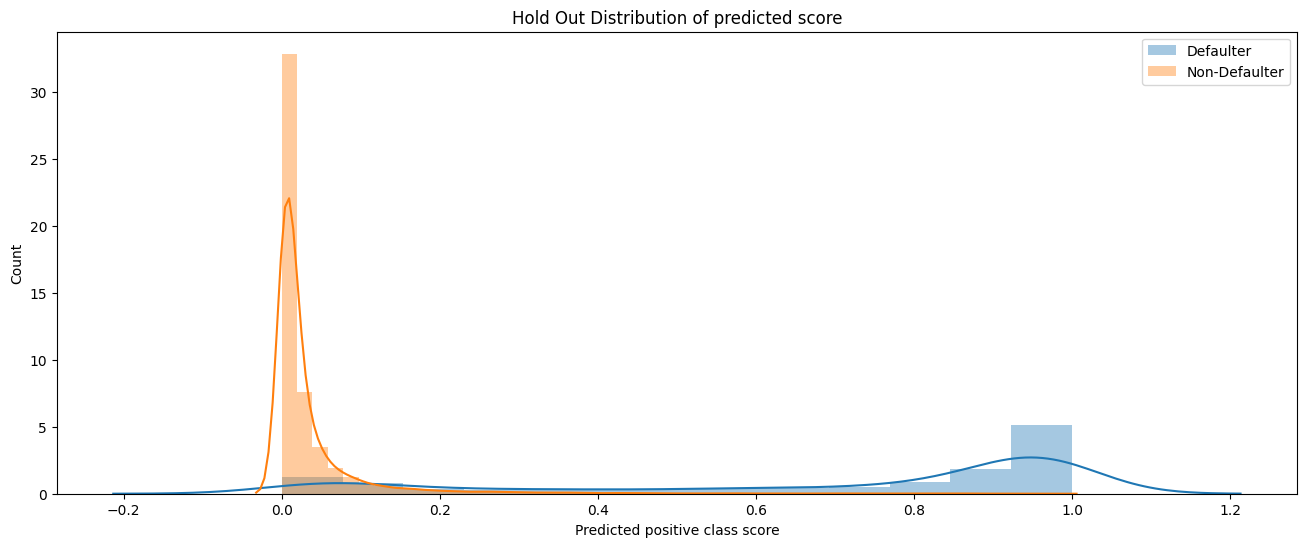

In [39]:
score_distribution([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out], ["Train","Val","Hold Out"])

## Feature Importance
### Split & Gain

In [40]:
feature_importance = pd.DataFrame({"feature":clf.feature_name(),"split":clf.feature_importance('split'), "gain":clf.feature_importance('gain')}).sort_values(by = 'gain', ascending = False)
feature_importance.iloc[:10,:]

,feature,split,gain
4,received_principal,8140,442117.261
7,interest_received_ratio,6914,268705.206
12,industry,1226,140634.732
3,total_payement,5845,129490.195
5,interest_received,3896,88885.044
14,work_experience,552,46334.458
11,tier_of_employment,1905,29678.155
0,total_income,2541,22366.545
10,employment_type,352,3008.691
1,dependents,453,1711.251


### SHAP

Literature about SHAP
<br>
- [Paper](https://arxiv.org/pdf/1705.07874.pdf)
- [Library](https://shap.readthedocs.io/en/latest/index.html)
</br>

**How to Read SHAP**
- Value of features on color scale vary from Blue to Red where Red is high and Blue is low
- Right Side of Grey Vertical Line is for class 1 and Left side is for Class 0

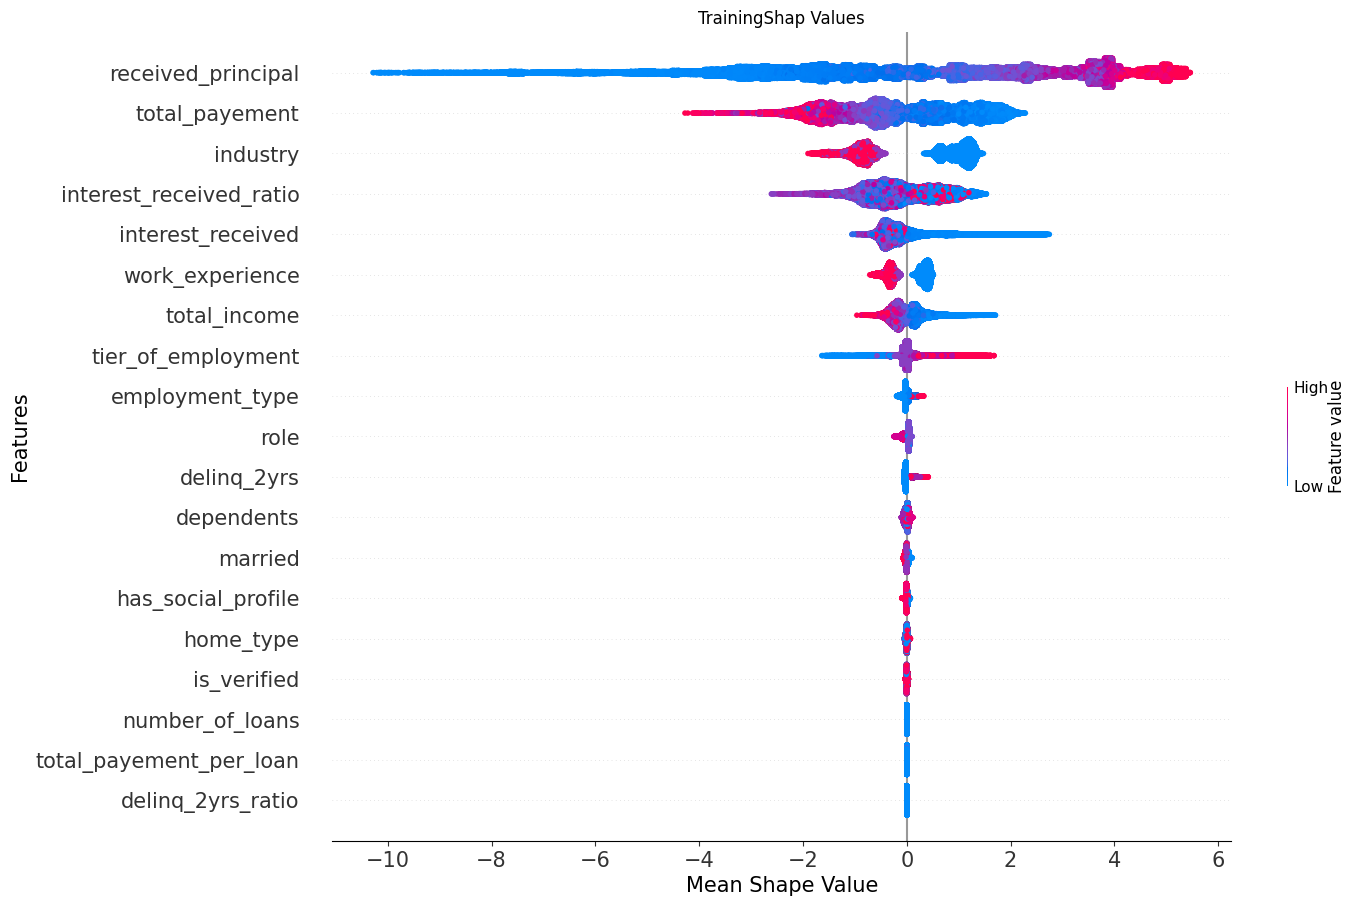

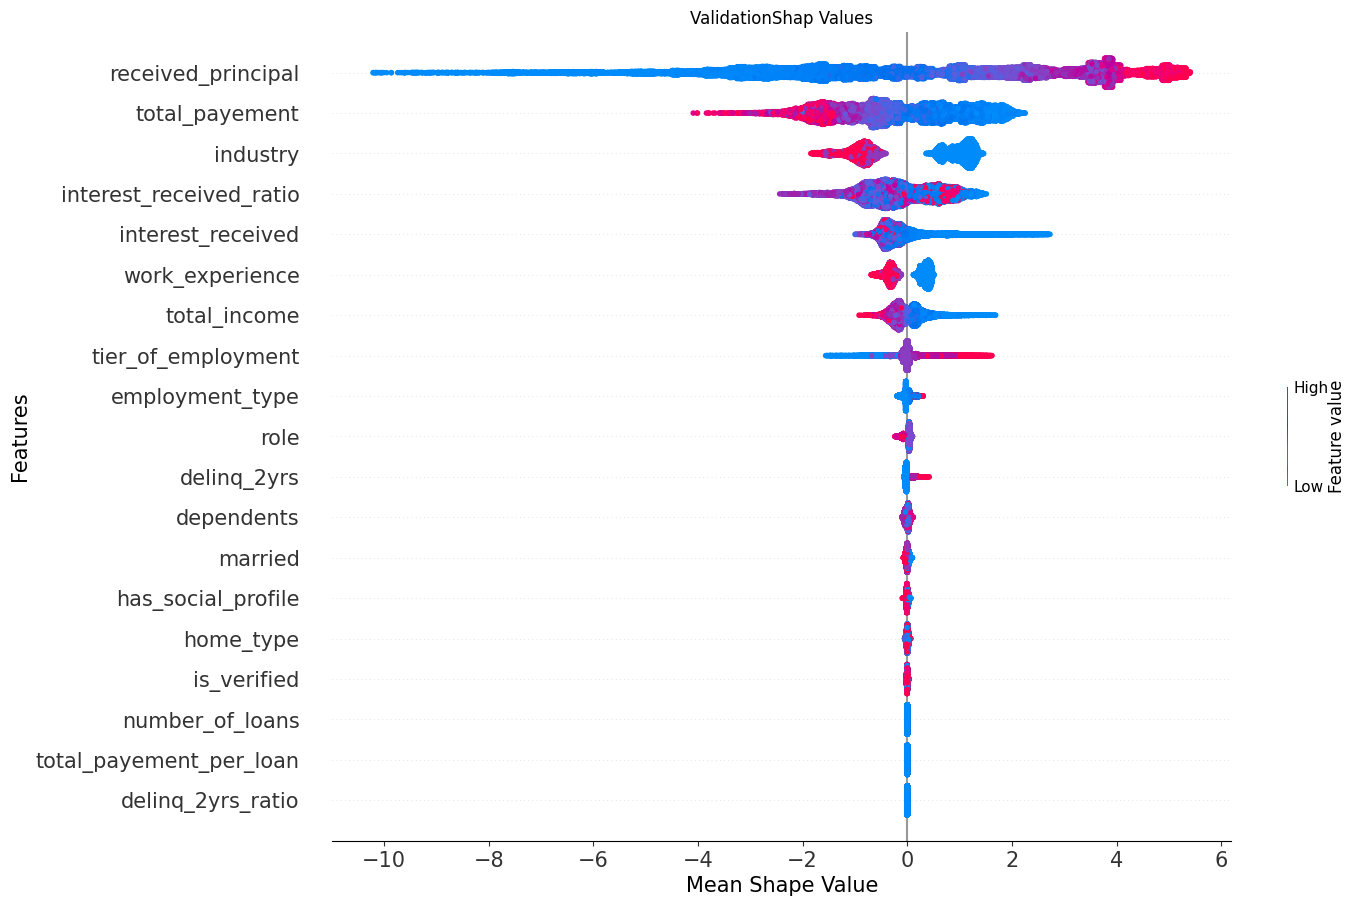

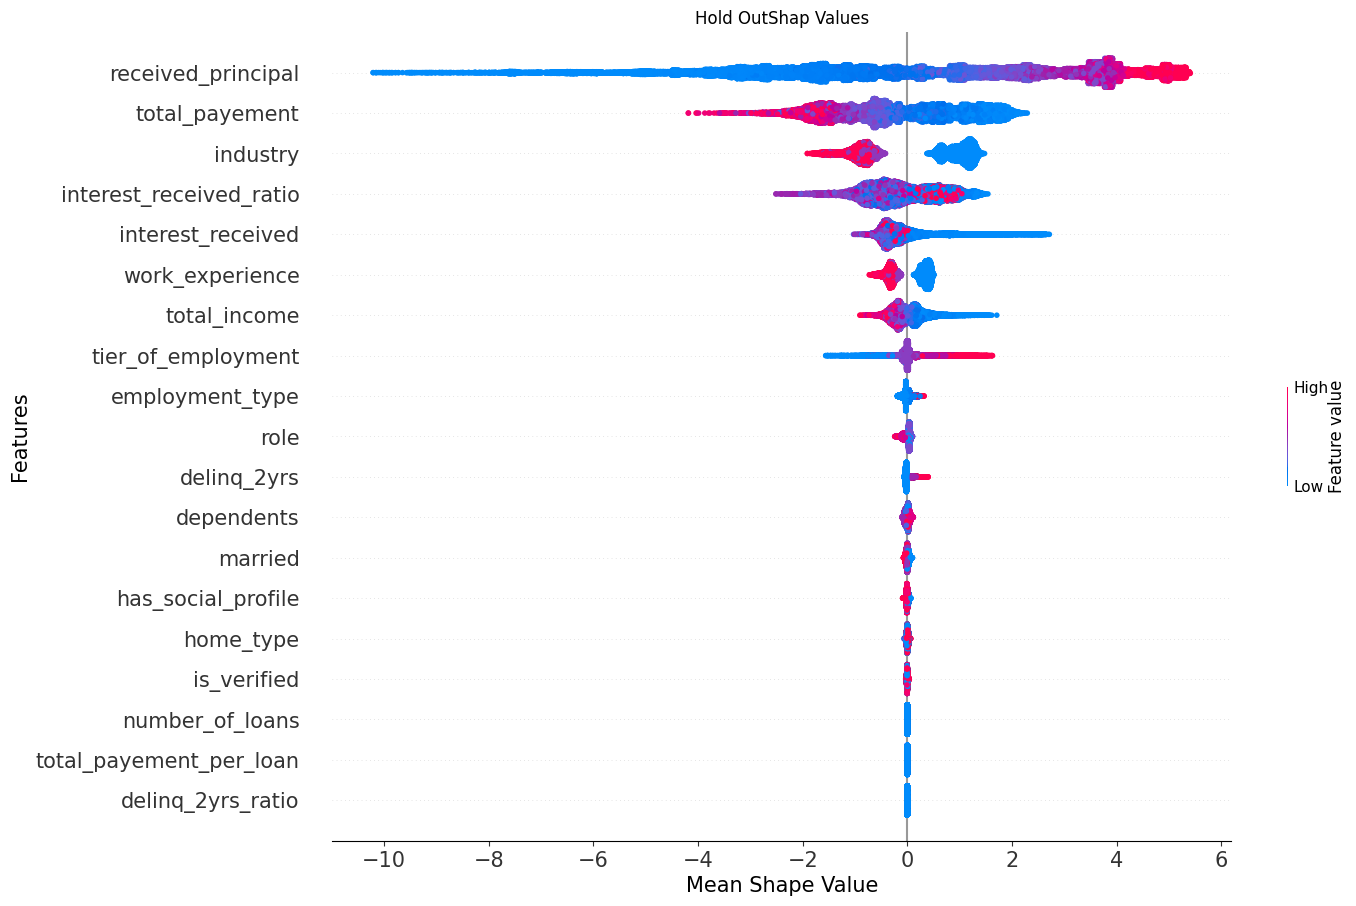

In [41]:
import shap
data_list = [train,val,hold_out]
data_type_list = ['Training', 'Validation', 'Hold Out']
shap_importance(clf, data_list, data_type_list)

Key Points
- Top features are consistent across Training, Validation, Hold Out (Higher the inconsistency, higher the chances the model is overfitting and will decay soon)

# Making Sense of Score
## Class Rate Curve

This Curve Tells 2 important things
1. Default rate across different score bucket for Train, Validation and Hold Out
2. User Distribution across different score bucket for Train, Validation and Hold Out

<br>
In Case User Distribution across different score bucket is very inconsistent in Train, Validation and Hold Out that means there is shift in domain of Out of Time Data

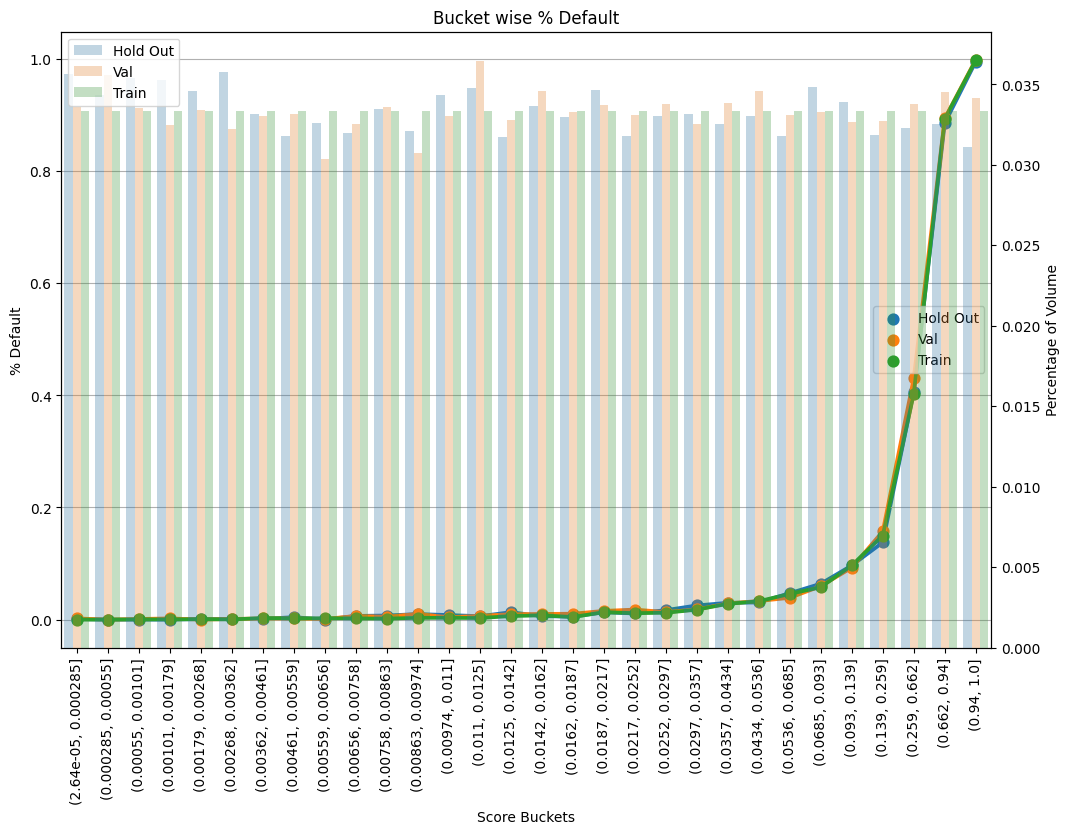

In [42]:
target_list = [train.label, val.label, hold_out.label]
pred_list = [pred_train, pred_val, pred_hold_out]
data_type_list = ['Train', 'Val', 'Hold Out']
class_rate(target_list, pred_list, data_type_list)

## Right Threshold

In [43]:
cutoff_score(val.label, pred_val, 0.01)

0.06616398453599784